In [ ]:
import os
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.utils import to_categorical
from google.colab import drive

drive.mount('/content/drive')
import os

librispeech_path = "/content/drive/MyDrive/LibriSpeech"

for root, dirs, files in os.walk(librispeech_path):
    for file in files:
        if file.endswith(".flac"):
            input_path = os.path.join(root, file)
            output_path = os.path.join(root, file.replace(".flac", ".wav"))
            os.system(f"ffmpeg -i {input_path} {output_path}")

Mounted at /content/drive


In [ ]:
import os


for root, dirs, files in os.walk(librispeech_path):
    for file in files:
        if file.endswith('.flac'):
            os.remove(os.path.join(root, file))


In [ ]:
import argparse
import json
import os
import wave


def main(data_directory, output_file):
    labels = []
    durations = []
    keys = []
    for group in os.listdir(data_directory):
        if group.startswith('.'):
            continue
        speaker_path = os.path.join(data_directory, group)
        for speaker in os.listdir(speaker_path):
            if speaker.startswith('.'):
                continue
            labels_file = os.path.join(speaker_path, speaker,
                                       '{}-{}.trans.txt'
                                       .format(group, speaker))
            for line in open(labels_file):
                split = line.strip().split()
                file_id = split[0]
                label = ' '.join(split[1:]).lower()
                audio_file = os.path.join(speaker_path, speaker,
                                          file_id) + '.wav'
                audio = wave.open(audio_file)
                duration = float(audio.getnframes()) / audio.getframerate()
                audio.close()
                keys.append(audio_file)
                durations.append(duration)
                labels.append(label)
    with open(output_file, 'w') as out_file:
        for i in range(len(keys)):
            line = json.dumps({'key': keys[i], 'duration': durations[i],
                              'text': labels[i]})
            out_file.write(line + '\n')
main("/content/drive/MyDrive/LibriSpeech/test-clean/", "valid_corpus.json")


In [ ]:
pip install python_speech_features

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for python_speech_features: filename=python_speech_features-0.6-py3-none-any.whl size=5886 sha256=0e869023148da2a9039d5d9cde0b832eafa158827b6a4920dd43153015de38e2
  Stored in directory: /root/.cache/pip/wheels/5a/9e/68/30bad9462b3926c29e315df16b562216d12bdc215f4d240294
Successfully built python_speech_features


In [ ]:
from data_generator import vis_train_features
vis_text, vis_raw_audio, vis_mfcc_feature, vis_spectrogram_feature, vis_audio_path = vis_train_features()

There are 2136 total training examples.


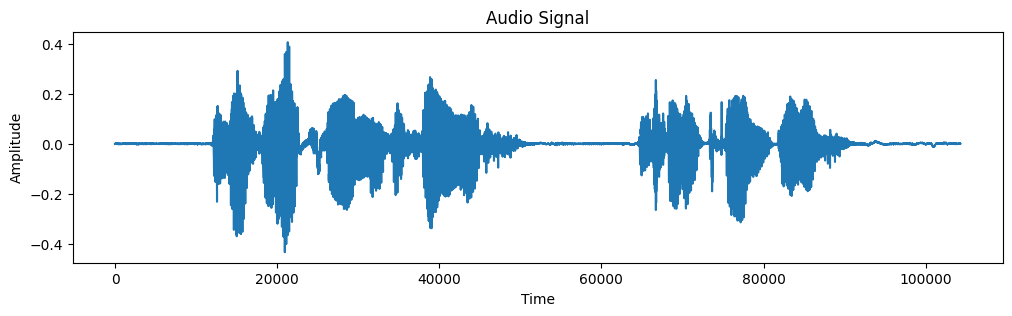

**Shape of Audio Signal** : (104297,)

**Transcript** : it was the afternoon of a holiday and she had closed early

In [ ]:
from IPython.display import Markdown, display
from data_generator import vis_train_features, plot_raw_audio
from IPython.display import Audio
%matplotlib inline
                                 
plot_raw_audio(vis_raw_audio)
display(Markdown('**Shape of Audio Signal** : ' + str(vis_raw_audio.shape)))
display(Markdown('**Transcript** : ' + str(vis_text)))
Audio(vis_audio_path)

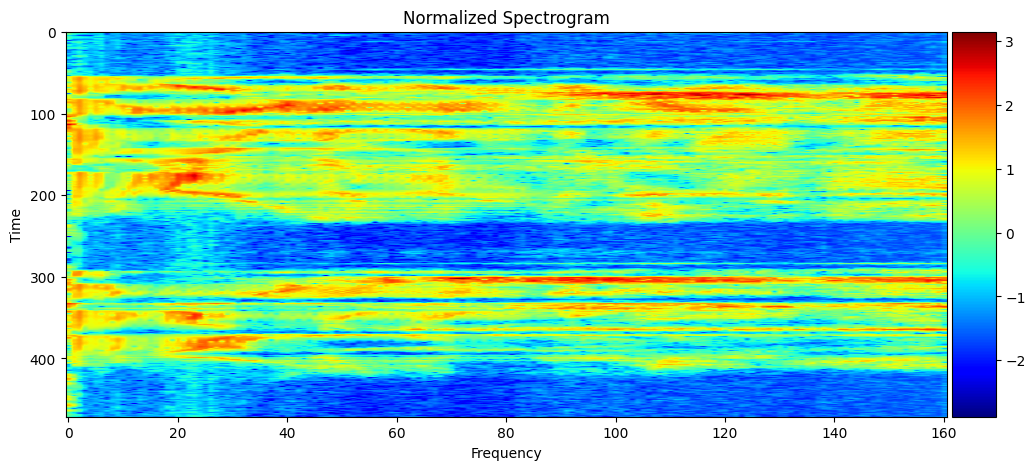

**Shape of Spectrogram** : (472, 161)

In [ ]:
from data_generator import plot_spectrogram_feature

# plot normalized spectrogram
plot_spectrogram_feature(vis_spectrogram_feature)
# print shape of spectrogram
display(Markdown('**Shape of Spectrogram** : ' + str(vis_spectrogram_feature.shape)))

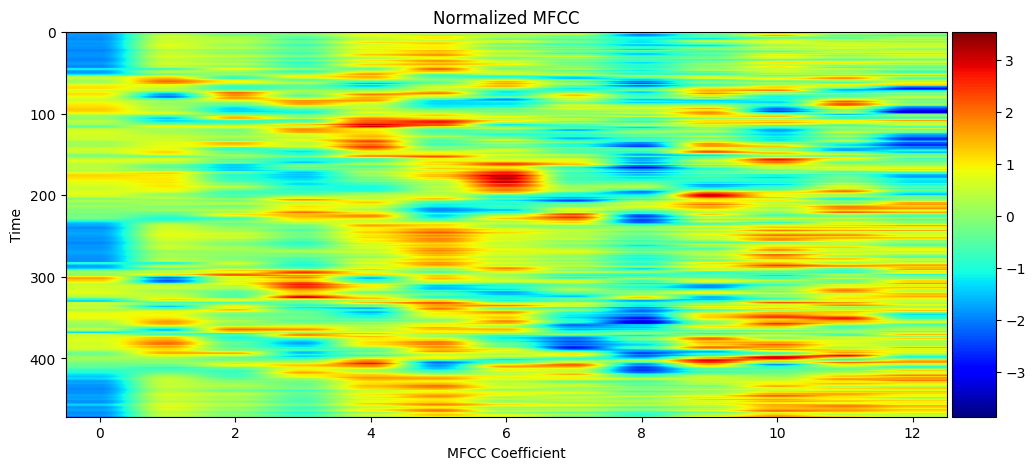

**Shape of MFCC** : (472, 13)

In [ ]:
from data_generator import plot_mfcc_feature

# plot normalized MFCC
plot_mfcc_feature(vis_mfcc_feature)
# print shape of MFCC
display(Markdown('**Shape of MFCC** : ' + str(vis_mfcc_feature.shape)))

In [ ]:
!KERAS_BACKEND=tensorflow python -c "from keras import backend"


2023-05-04 02:26:11.993932: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-04 02:26:13.030750: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'


In [ ]:
#GPU preparation
from keras.backend import set_session
import tensorflow as tf 
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10240)])
  except RuntimeError as e:
    print(e)
%load_ext autoreload
%autoreload 2
from sample_models import *
from train_utils import train_model

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
model_2 = cnn_rnn_model(input_dim=161,
                        filters=200,
                        kernel_size=11, 
                        conv_stride=2,
                        conv_border_mode='valid',
                        units=200)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 the_input (InputLayer)      [(None, None, 161)]       0         
                                                                 
 conv1d (Conv1D)             (None, None, 200)         354400    
                                                                 
 bn_conv_1d (BatchNormalizat  (None, None, 200)        800       
 ion)                                                            
                                                                 
 rnn (CuDNNGRU)              (None, None, 200)         241200    
                                                                 
 batch_normalization (BatchN  (None, None, 200)        800       
 ormalization)                                                   
                                                                 
 time_distributed (TimeDistr  (None, None, 29)         5829  

In [ ]:
train_model(input_to_softmax=model_2, 
            pickle_path='model_2.pickle', 
            save_model_path='model_2.h5', 
            spectrogram=True) 

/content/train_utils.py:74: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(generator=audio_gen.next_train(), steps_per_epoch=steps_per_epoch,


Epoch 1/30
106/106 [==============================] - 2701s 26s/step - loss: 220.3534 - val_loss: 183.6432
Epoch 2/30
106/106 [==============================] - 67s 636ms/step - loss: 159.3237 - val_loss: 147.5752
Epoch 3/30
106/106 [==============================] - 53s 499ms/step - loss: 138.8439 - val_loss: 137.0643
Epoch 4/30
106/106 [==============================] - 69s 655ms/step - loss: 128.2135 - val_loss: 137.1082
Epoch 5/30
106/106 [==============================] - 52s 493ms/step - loss: 120.4795 - val_loss: 127.9033
Epoch 6/30
106/106 [==============================] - 69s 655ms/step - loss: 113.6632 - val_loss: 124.9341
Epoch 7/30
106/106 [==============================] - 69s 654ms/step - loss: 108.7118 - val_loss: 125.1747
Epoch 8/30
106/106 [==============================] - 53s 498ms/step - loss: 103.5405 - val_loss: 124.5722
Epoch 9/30
106/106 [==============================] - 69s 654ms/step - loss: 99.4008 - val_loss: 123.8396
Epoch 10/30
106/106 [=================